Code to accompany Machine Learning Recipes #8. We'll write a Decision Tree Classifier, in pure Python. Below each of the methods, I've written a little demo to help explain what it does.

Decision trees 

**Exercise 1**

I implemented CART algorithm on my own for better understanding

In [9]:
import pydot

training_data = [[1, 1, 2, 2, 1], [2, 1, 2, 2, 1], [1, 1, 1, 2, -1], [1, 2, 1, 2, 1], [2, 3, 2, 2, -1],
            [2, 2, 1, 2, -1], [3, 2, 2, 1, 1], [1, 3, 2, 2, 1], [3, 3, 2, 1, 1 ], [2, 3, 1, 2, 1],
            [3, 1, 1, 1, 1], [1, 2, 1, 1, 1], [2, 3, 1, 1, -1], [2, 1, 1, 2, -1], [2, 2, 1, 1, -1]]

header = ["Location", "Category", "Gender",  "Product review", "Decision"]



def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])


def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  
    for row in rows:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts



def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)


class Question:

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        val = example[self.column]
        return val == self.value



def partition(rows, question):
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows


def gini(rows):
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity



def info_gain(left, right, current_uncertainty):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)




def find_best_split(rows):
    best_gain = 0  
    best_question = None 
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1 

    for col in range(n_features):  

        values = set([row[col] for row in rows]) 

        for val in values: 

            question = Question(col, val)

            true_rows, false_rows = partition(rows, question)

            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

      
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain > best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question


class Leaf:

    def __init__(self, rows):
        self.predictions = class_counts(rows)


class Decision_Node:

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

build_rows = []


def build_tree(rows):
    
    gain, question = find_best_split(rows)

    if gain == 0:
        return Leaf(rows)

    true_rows, false_rows = partition(rows, question)

    true_branch = build_tree(true_rows)

    false_branch = build_tree(false_rows)

    tr = [training_data.index(i) for i in true_rows ]

    fr = [training_data.index(i) for i in false_rows ]

    rw = [training_data.index(i) for i in rows ]

    build_rows.append([str(rw), str(tr)])
    build_rows.append([str(rw), str(fr)])

    return Decision_Node(question, true_branch, false_branch)



my_tree = build_tree(training_data)


print(build_rows)

[['[1, 4, 9, 12, 13]', '[12]'], ['[1, 4, 9, 12, 13]', '[1, 4, 9, 13]'], ['[1, 4, 5, 9, 12, 13, 14]', '[5, 14]'], ['[1, 4, 5, 9, 12, 13, 14]', '[1, 4, 9, 12, 13]'], ['[0, 2]', '[2]'], ['[0, 2]', '[0]'], ['[0, 2, 10]', '[0, 2]'], ['[0, 2, 10]', '[10]'], ['[0, 2, 3, 6, 7, 8, 10, 11]', '[0, 2, 10]'], ['[0, 2, 3, 6, 7, 8, 10, 11]', '[3, 6, 7, 8, 11]'], ['[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]', '[1, 4, 5, 9, 12, 13, 14]'], ['[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]', '[0, 2, 3, 6, 7, 8, 10, 11]']]


In [10]:

def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')

    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('cart_tree.png', format='png')

# build_rows = list(reversed(build_rows))
plot_tree(build_rows)


def classify(row, node):
    if isinstance(node, Leaf):
        return node.predictions

    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)


def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs


for row in training_data:
    message = "Actual: {} for row {}  Predicted: {}".format(row[-1] , row, print_leaf(classify(row, my_tree)))
    print(message)

Actual: 1 for row [1, 1, 2, 2, 1]  Predicted: {1: '100%'}
Actual: 1 for row [2, 1, 2, 2, 1]  Predicted: {1: '50%', -1: '50%'}
Actual: -1 for row [1, 1, 1, 2, -1]  Predicted: {-1: '100%'}
Actual: 1 for row [1, 2, 1, 2, 1]  Predicted: {1: '100%'}
Actual: -1 for row [2, 3, 2, 2, -1]  Predicted: {1: '50%', -1: '50%'}
Actual: -1 for row [2, 2, 1, 2, -1]  Predicted: {-1: '100%'}
Actual: 1 for row [3, 2, 2, 1, 1]  Predicted: {1: '100%'}
Actual: 1 for row [1, 3, 2, 2, 1]  Predicted: {1: '100%'}
Actual: 1 for row [3, 3, 2, 1, 1]  Predicted: {1: '100%'}
Actual: 1 for row [2, 3, 1, 2, 1]  Predicted: {1: '50%', -1: '50%'}
Actual: 1 for row [3, 1, 1, 1, 1]  Predicted: {1: '100%'}
Actual: 1 for row [1, 2, 1, 1, 1]  Predicted: {1: '100%'}
Actual: -1 for row [2, 3, 1, 1, -1]  Predicted: {-1: '100%'}
Actual: -1 for row [2, 1, 1, 2, -1]  Predicted: {1: '50%', -1: '50%'}
Actual: -1 for row [2, 2, 1, 1, -1]  Predicted: {-1: '100%'}


**Exercise 2**

In [11]:
class Leaf:

    def __init__(self, elements, labels, ids):
        self.child_leafs = []
        self.elements = elements
        self.labels = labels
        self.completed = False
        self.ids = ids

    def get_elements(self):
        return self.elements

    def set_child_leafs(self, new_leafs):
        self.child_leafs = new_leafs

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def get_child_leafs(self):
        return self.child_leafs

    def get_ids(self):
        return self.ids

In [12]:
import numpy as np
from math import log

labels = [1,1,-1,1,-1,-1,1,1,1,1,1,1,-1,-1,-1]
data_set = [[1,1,2,2],[2,1,2,2],[1,1,1,2],[1,2,1,2],[2,3,2,2],
                [2,2,1,2],[3,2,2,1],[1,3,2,2],[3,3,2,1],[2,3,1,2],
                [3,1,1,1],[1,2,1,1],[2,3,1,1],[2,1,1,2],[2,2,1,1]]


ids = list(range(len(data_set)))
root = Leaf(data_set, labels, ids)
current_node = root


def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()

def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node

def find_leaf_not_completed(root):
    return is_leaf_completed(root)


def calculate_split_candidate_entropy(full_entropy, labels, elements, unique_labels, unique_elements, iter):
    split_entropy = 0
    for i in range(len(unique_elements)):
        indices = np.where(np.array(elements)[..., iter].tolist() == unique_elements[i])
        unique_size = len(indices[0].tolist())
        filtered_labels = np.array(labels)[indices]
        for j in range(len(unique_labels)):
            labels_count = filtered_labels.tolist().count(unique_labels[j])
            if labels_count > 0:
                log2 = log((labels_count * 1.0) / (unique_size * 1.0), 2)
            else:
                log2 = 0.0
            split_entropy = split_entropy - 1.0 * (
                    (labels_count * 1.0) / unique_size * 1.0) * log2 * unique_size * 1.0 / len(elements) * 1.0
    return (full_entropy - split_entropy)



def calculate_entropy(labels):
    unique_labels, labels_count = np.unique(labels, return_counts=True)
    entropy = 0
    size = len(labels)
    for i in range(len(unique_labels)):
        if labels_count[i] > 0:
            log2 = log((labels_count[i] * 1.0) / (size * 1.0), 2)
        else:
            log2 = 0.0
        entropy = entropy - 1.0 * ((labels_count[i] * 1.0) / size) * log2
    return entropy



def split(current_node, split_values, column_id, split_history):
    new_leafs = []
    for i in range(len(split_values)):
        indices = np.where(np.array(current_node.get_elements())[..., column_id].tolist() == split_values[i])
        new_leaf_elements = np.array(current_node.get_elements())[indices].tolist()
        new_leaf_labels   = np.array(current_node.get_labels())[indices].tolist()
        new_leaf_ids = np.array(current_node.get_ids())[indices].tolist()
        new_leaf = Leaf(new_leaf_elements,new_leaf_labels, new_leaf_ids)
        split_history.append([str(current_node.ids), str(new_leaf_ids)])
        if len(np.unique(new_leaf_labels)) == 1:
            new_leaf.set_completed()
        new_leafs.append(new_leaf)
    current_node.set_child_leafs(new_leafs)
    current_node.set_completed()
    return current_node, split_history



def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()

def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique

def is_leaf_completed(node):
    if node.is_completed():
        child_nodes = node.get_child_leafs()
        if len(child_nodes) == 0:
            return None
        is_child_to_return = False
        for i in range(len(child_nodes)):
            if not child_nodes[i].is_completed():
                return child_nodes[i]
            else:
                new_node = is_leaf_completed(child_nodes[i])
                if new_node != None:
                    is_child_to_return=True
        if is_child_to_return:
            return new_node
    return node

def find_leaf_not_completed(root_node):
    return is_leaf_completed(root_node)

def get_current_node(root):
    return find_leaf_not_completed(root)



def build(root):
    stop_criterion = False
    split_history = []
    current_node = root
    unique_labels = get_unique_labels(root.get_labels())
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        full_entropy = calculate_entropy(current_node.get_labels())
        max_entropy_id = 0
        max_entropy_value = 0
        for i in range(len(unique_values)):
            split_entropy = calculate_split_candidate_entropy(full_entropy,
                                                                      current_node.get_labels(),
                                                                      current_node.get_elements(),
                                                                      unique_labels,
                                                                      unique_values[i], i)
            if split_entropy > max_entropy_value:
                max_entropy_id = i
                max_entropy_value = split_entropy
        current_node, split_history = split(current_node, unique_values[max_entropy_id], max_entropy_id, split_history)
        new_node = get_current_node(root)
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root, split_history



c45_tree, split_history_c45 = build(root)


print(split_history_c45)


[['[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]', '[0, 2, 3, 7, 11]'], ['[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]', '[1, 4, 5, 9, 12, 13, 14]'], ['[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]', '[6, 8, 10]'], ['[0, 2, 3, 7, 11]', '[0, 2]'], ['[0, 2, 3, 7, 11]', '[3, 11]'], ['[0, 2, 3, 7, 11]', '[7]'], ['[1, 4, 5, 9, 12, 13, 14]', '[1, 13]'], ['[1, 4, 5, 9, 12, 13, 14]', '[5, 14]'], ['[1, 4, 5, 9, 12, 13, 14]', '[4, 9, 12]']]


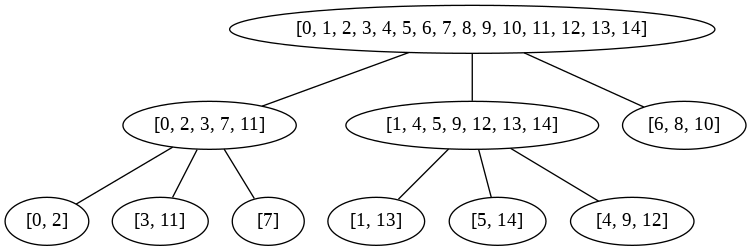

In [13]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        edge = pydot.Edge(split[0], split[1])
        tree.add_edge(edge)
    tree.write('c45_tree.png', format='png')
    
plot_tree(split_history_c45)

from IPython.display import Image
Image(filename='c45_tree.png')

**Exercise 3**

In [14]:
import math
import numpy as np
import copy

N = 2

labels = [1,1,-1,1,-1,-1,1,1,1,1,1,1,-1,-1,-1]
data_set = [[1,1,2,2],[2,1,2,2],[1,1,1,2],[1,2,1,2],[2,3,2,2],
                [2,2,1,2],[3,2,2,1],[1,3,2,2],[3,3,2,1],[2,3,1,2],
                [3,1,1,1],[1,2,1,1],[2,3,1,1],[2,1,1,2],[2,2,1,1]]

class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.elements = elements
        self.split_feature = None
        self.split_value = None
        self.labels = labels
        self.completed = False
        self.ids = ids
        self.validated = False

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def set_split(self, feature):
        self.split_feature = feature

    def get_split(self):
        return self.split_feature

    def set_split_value(self, value):
        self.split_value = value

    def get_split_value(self):
        return self.split_value

    def set_validated(self):
        self.validated = True

    def is_validated(self):
        return self.validated

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids


labels_count = len(np.unique(labels))

ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root


def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()


def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique


def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node


def find_leaf_not_completed(root):
    return is_leaf_completed(root)


def get_split_candidates(unique_values):
    split_list = []
    for i in range(len(unique_values)):
        current_list = []
        temp_list = copy.deepcopy(unique_values)
        current_list.append(temp_list[i])
        del temp_list[i]
        current_list.append(temp_list)
        split_list.append(current_list)
    return split_list


def get_number_of_labels_for_value(elements, column_id, label):
    count = 0
    if not isinstance(elements, list):
        elements_list = [elements]
    else:
        elements_list = elements

    column_elements = get_node_elements_column(column_id)

    for i in range(len(elements_list)):
        for j in range(len(column_elements)):
            if column_elements[j] == elements_list[i]:
                if current_node.labels[j] == label:
                    count = count + 1
    return count


def get_node_elements_column(column_id):
    return np.array(current_node.elements)[..., column_id].tolist()


def count_number_of_elements(elements, column_id):
    count = 0
    if isinstance(elements, list):
        column_elements = get_node_elements_column(column_id)
        for i in range(len(elements)):
            count = count + column_elements.count(elements[i])
    else:
        count = count + get_node_elements_column(column_id).count(elements)
    return count


def calculate_omega(elements, column_id):
    t_l = count_number_of_elements(elements[0], column_id)
    t_r = count_number_of_elements(elements[1], column_id)
    p_l = t_l * 1.0 / len(current_node.elements) * 1.0
    p_r = t_r * 1.0 / len(current_node.elements) * 1.0

    sum_p = 0
    labels = get_unique_labels(current_node.labels)
    for i in range(labels_count):
        p_class_t_l = (get_number_of_labels_for_value(elements[0], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[0], column_id) * 1.0)
        p_class_t_r = (get_number_of_labels_for_value(elements[1], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[1], column_id) * 1.0)
        sum_p = sum_p + math.fabs(p_class_t_l - p_class_t_r)
    return 2.0 * p_l * p_r * sum_p


def check_completed(labels, elements):
    ratio = len(get_unique_labels(labels))
    if ratio == 1:
        return True
    elements = sorted(elements)
    duplicated = [elements[i] for i in range(len(elements)) if i == 0 or elements[i] != elements[i - 1]]
    if len(duplicated) == 1:
        return True
    return False

def build(root_node):
    current_node = root_node
    stop_criterion = False
    split_history = []
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        max_unique_id = 0
        max_split_id = 0
        max_value = 0
        for i in range(len(unique_values)):
            if len(unique_values[i]) == 1:
                continue
            split_candidates = get_split_candidates(unique_values[i].tolist())
            for j in range(len(split_candidates)):
                current_value = calculate_omega(split_candidates[j], i)
                if max_value < current_value:
                    max_unique_id = i
                    max_split_id = j
                    max_value = current_value
        current_node, split_history = split_node(current_node, unique_values[max_unique_id][max_split_id],
                                                 max_unique_id, split_history)
        new_node = find_leaf_not_completed(root_node)
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root_node, split_history


def split_node(current_node, value, split_id, split_history):
    left_leaf = []
    left_leaf_labels = []
    left_leaf_ids = []
    right_leaf = []
    right_leaf_labels = []
    right_leaf_ids = []
    for i in range(len(current_node.elements)):
        if current_node.elements[i][split_id] == value:
            left_leaf.append(current_node.elements[i])            
            left_leaf_labels.append(current_node.labels[i])
            left_leaf_ids.append(current_node.ids[i])
        else:                   
            right_leaf.append(current_node.elements[i])
            right_leaf_labels.append(current_node.labels[i])
            right_leaf_ids.append(current_node.ids[i])
    if len(right_leaf_labels) == 0 or len(left_leaf_labels) == 0:
        current_node.set_completed()
        return current_node, split_history
    split_history.append([str(current_node.ids), str(left_leaf_ids)])
    split_history.append([str(current_node.ids), str(right_leaf_ids)])
    # change the code here:                
    current_node.set_L(BinaryLeaf(left_leaf, left_leaf_labels, left_leaf_ids))
    current_node.set_R(BinaryLeaf(right_leaf, right_leaf_labels, right_leaf_ids))
    # current_node.set_split(split_id)
    # current_node.set_split_value(value)
    current_node.set_completed()
    if check_completed(left_leaf_labels, left_leaf):
        current_node.L.set_completed()
    if check_completed(right_leaf_labels, right_leaf):
        current_node.R.set_completed()
    ####        
    return current_node, split_history


cart_tree, split_history_cart = build(current_node)

print(split_history_cart)


[['[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]', '[1, 4, 5, 9, 12, 13, 14]'], ['[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]', '[0, 2, 3, 6, 7, 8, 10, 11]'], ['[1, 4, 5, 9, 12, 13, 14]', '[5, 9, 12, 13, 14]'], ['[1, 4, 5, 9, 12, 13, 14]', '[1, 4]'], ['[0, 2, 3, 6, 7, 8, 10, 11]', '[2, 3, 10, 11]'], ['[0, 2, 3, 6, 7, 8, 10, 11]', '[0, 6, 7, 8]'], ['[5, 9, 12, 13, 14]', '[12, 14]'], ['[5, 9, 12, 13, 14]', '[5, 9, 13]'], ['[2, 3, 10, 11]', '[10, 11]'], ['[2, 3, 10, 11]', '[2, 3]']]


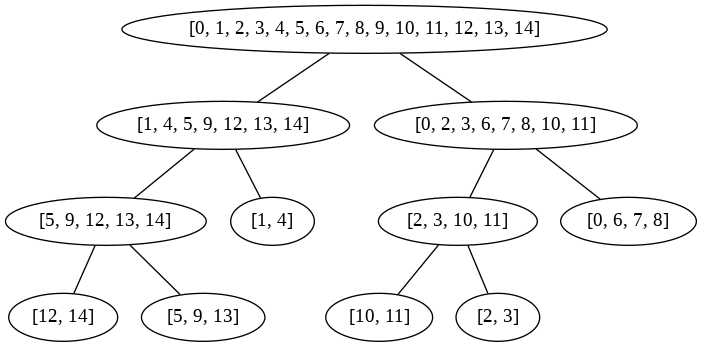

In [15]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        edge = pydot.Edge(split[0], split[1])
        tree.add_edge(edge)
    tree.write('prune_tree.png', format='png')
    
plot_tree(split_history_cart)

from IPython.display import Image
Image(filename='prune_tree.png')